node degree clustering
0 4 0.3333333333333333
1 5 0.3
2 4 0.16666666666666666
3 4 0.5
4 4 0.16666666666666666
5 2 0
6 2 0
7 5 0.3
8 5 0.2
9 5 0.3

the adjacency list
0 8 2 9 1
1 2 4 9 3
2 7 6
3 9 8 7
4 7 6 8
5 8 9
6
7 9 8
8
9


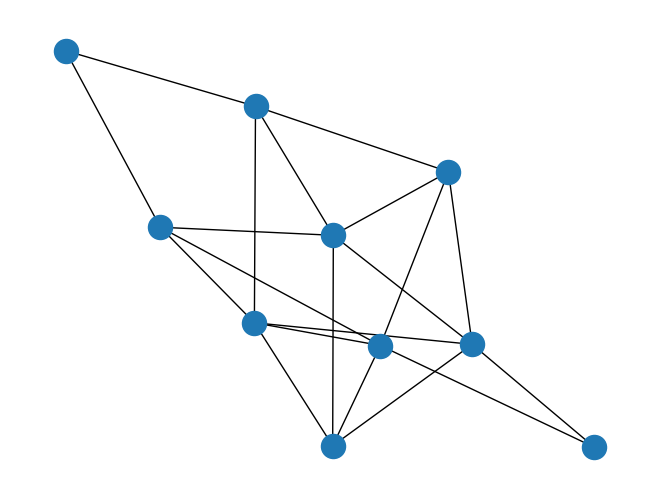

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import networkx as nx
from typing import List

n = 10  # 50 nodes
m = 20  # 100 edges
seed = 20160  # seed random number generators for reproducibility

# Use seed for reproducibility
G = nx.gnm_random_graph(n, m, seed=seed)
# G = nx.barabasi_albert_graph(n, m, seed=seed)

# some properties
print("node degree clustering")
for v in nx.nodes(G):
    print(f"{v} {nx.degree(G, v)} {nx.clustering(G, v)}")

print()
print("the adjacency list")
for line in nx.generate_adjlist(G):
    print(line)

pos = nx.spring_layout(G, seed=seed)  # Seed for reproducible layout
nx.draw(G, pos=pos)
plt.show()

In [2]:
ls = nx.to_numpy_array(G)

In [3]:
ed = nx.to_edgelist(G)

In [4]:
ed

EdgeDataView([(0, 8, {}), (0, 2, {}), (0, 9, {}), (0, 1, {}), (1, 2, {}), (1, 4, {}), (1, 9, {}), (1, 3, {}), (2, 7, {}), (2, 6, {}), (3, 9, {}), (3, 8, {}), (3, 7, {}), (4, 7, {}), (4, 6, {}), (4, 8, {}), (5, 8, {}), (5, 9, {}), (7, 9, {}), (7, 8, {})])

In [545]:
for (u,v) in g.edges:
    g[u][v]['flow'] = 2

AttributeError: 'numpy.ndarray' object has no attribute 'edges'

In [6]:
nx.to_pandas_edgelist(G)

,source,target,flow
0,0,8,2
1,0,2,2
2,0,9,2
3,0,1,2
4,1,2,2
5,1,4,2
6,1,9,2
7,1,3,2
8,2,7,2
9,2,6,2


In [7]:
A = nx.adjacency_matrix(G, weight="flow")
A.todense()

array([[0, 2, 2, 0, 0, 0, 0, 0, 2, 2],
       [2, 0, 2, 2, 2, 0, 0, 0, 0, 2],
       [2, 2, 0, 0, 0, 0, 2, 2, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 2, 2, 2],
       [0, 2, 0, 0, 0, 0, 2, 2, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
       [0, 0, 2, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 2, 2, 2, 0, 0, 0, 2, 2],
       [2, 0, 0, 2, 2, 2, 0, 2, 0, 0],
       [2, 2, 0, 2, 0, 2, 0, 2, 0, 0]])

In [8]:
A = nx.adjacency_matrix(G, weight="weight")
A.todense()

array([[0, 1, 1, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 1, 1, 1, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 1, 1],
       [1, 0, 0, 1, 1, 1, 0, 1, 0, 0],
       [1, 1, 0, 1, 0, 1, 0, 1, 0, 0]])

In [9]:
ls

array([[0., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
       [1., 0., 1., 1., 1., 0., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0., 0., 1., 1.],
       [1., 0., 0., 1., 1., 1., 0., 1., 0., 0.],
       [1., 1., 0., 1., 0., 1., 0., 1., 0., 0.]])

## Testing Inner-GA

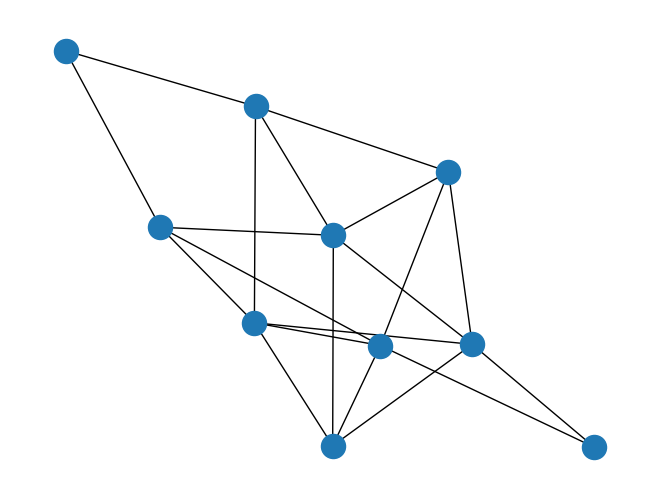

In [10]:
n = 10  # 50 nodes
m = 20  # 100 edges
seed = 20160  # seed random number generators for reproducibility

# Use seed for reproducibility
G = nx.gnm_random_graph(n, m, seed=seed)
pos = nx.spring_layout(G, seed=seed)  # Seed for reproducible layout
nx.draw(G, pos=pos)
plt.show()

In [11]:
import numpy as np
from numpy.random import randint, uniform, random
# for (i,(u, v)) in enumerate(G.edges):
    # print(i, G[u][v])
    # capacity = np.random.randint(100, 600)
    # G[u][v]['link'] = i
    # G[u][v]['capacity'] = capacity
    # G[u][v]['flow'] = np.random.uniform(low=1, high=capacity*0.95)


In [12]:
# nx.to_edgelist(G)

In [13]:
# nx.adjacency_matrix(G, weight="capacity").todense()

In [14]:
# nx.adjacency_matrix(G, weight="flow").todense()

In [15]:
links = [x for x in G.edges()]
capacity =  np.array([randint(100, 350) for _ in range(len(links))])
flow = np.array([uniform(1, x*0.95) for x in capacity])

In [16]:
def generate_population(size: int, capacity: list):
    population = []
    for _ in range(size):
        population.append([uniform(1, x*0.95) for x in capacity])
    return np.array(population)

In [17]:
population = generate_population(20, capacity)

In [18]:
population

array([[ 90.28829039,  79.29334456,  41.13277262,  68.96226809,
        172.89527225, 165.65612521, 277.61100094,  72.44231581,
         53.22706093,  15.54237907, 124.37638968,  11.04765796,
         84.97380298,  39.24850942,  84.45455078,  69.29881244,
          3.9568805 ,  16.9780872 ,  56.72738153, 217.9295869 ],
       [234.45227628, 187.08955606,  95.02937644, 186.69646652,
         52.93929856, 227.12357064,  55.24099998,  42.27001508,
         71.53582863,  36.91178177,  70.7826212 ,  45.80932476,
         82.05568481,  65.24190186,  29.67287289,  52.91882908,
         48.1331215 ,  10.78848604, 103.57701243, 142.51201445],
       [109.9515299 , 112.69508437, 117.76207169,  48.40231254,
        269.88194922,  90.56617542, 238.35484401, 138.15854579,
         83.48345052, 117.23256766,  47.96715442, 114.42209294,
         62.95153706,  34.79986123, 113.98026311,  23.14607569,
         78.36568921, 112.79604651,  65.48986059,  37.91598549],
       [259.56894997, 126.84605084, 1

In [19]:
def scatter_crossover(parent1: np.array, parent2: np.array, alpha: int, indpb = 0.8):
    if random() > indpb:
        return False
        
    c1 = np.copy(parent1)
    c2 = np.copy(parent2)
    
    n_genes = len(parent1)
    scatter_point = np.random.choice(n_genes, size=int(alpha * n_genes), replace=False)
    
    for i in scatter_point:
        c1[i] = parent2[i]
        c2[i] = parent1[i]
    
    return c1, c2

In [20]:
scatter_crossover(population[0], population[1], 0.5)

(array([ 90.28829039, 187.08955606,  41.13277262,  68.96226809,
         52.93929856, 165.65612521,  55.24099998,  72.44231581,
         71.53582863,  36.91178177,  70.7826212 ,  11.04765796,
         82.05568481,  39.24850942,  29.67287289,  52.91882908,
          3.9568805 ,  16.9780872 , 103.57701243, 217.9295869 ]),
 array([234.45227628,  79.29334456,  95.02937644, 186.69646652,
        172.89527225, 227.12357064, 277.61100094,  42.27001508,
         53.22706093,  15.54237907, 124.37638968,  45.80932476,
         84.97380298,  65.24190186,  84.45455078,  69.29881244,
         48.1331215 ,  10.78848604,  56.72738153, 142.51201445]))

In [680]:
def fitness_inga(capacity: np.array, flow: np.array):
    sigma = flow.sum()
    temp = (flow/(capacity-flow)).sum()
    T = temp/sigma
    return 1/T

def gautil(flow: np.array, capacity: np.array):
    return flow/capacity

In [683]:
fitness_inga(capacity, population[19])

62.62032387866123

In [682]:
gautil(population[0], capacity)

array([0.26712512, 0.36207007, 0.22600425, 0.34829428, 0.59414183,
       0.49896423, 0.81172807, 0.45849567, 0.46690404, 0.12534177,
       0.92130659, 0.06655216, 0.75869467, 0.29733719, 0.61645658,
       0.69298812, 0.0245769 , 0.14148406, 0.28650193, 0.83819072])

In [1025]:
def tournament_selection(size: int, pop: np.array, fitness: np.array, k=5):
   
    index = [] 
    population = list(pop)
    select = []
    for _ in range(size):
        selection_ix = randint(len(population))
        for ix in np.random.randint(0, len(population), k-1):
            if fitness[ix] > fitness[selection_ix]:
                selection_ix = ix
        select.append(population.pop(selection_ix))
        index.append(selection_ix)

    return np.array(select), np.array(index)

In [1028]:
from deap.tools import mutGaussian

def innerga(size=10, generasi=100, capacity=None, alpha=0.5, pMu=0.2, pCr=0.8):
    pop = generate_population(size, capacity)
    
    for gen in range(generasi):
        fitness = np.array([fitness_inga(capacity=capacity, flow=ind) for ind in pop])
        
        selected, _ = tournament_selection(size=size,pop=pop, fitness=fitness)
        
        sh = selected[0].shape[0]
        offspring = np.empty((0, sh))
        
        for p1, p2 in zip(selected[::2], selected[1::2]):
            if cross := scatter_crossover(alpha=alpha, parent1=p1, parent2=p2, indpb=pCr):
                c1, c2 = cross
                offspring = np.append(offspring, c1.reshape(1, sh), axis=0)
                offspring = np.append(offspring, c2.reshape(1, sh), axis=0)
            else:
                offspring = np.append(offspring, p1.reshape(1, sh), axis=0)
                offspring = np.append(offspring, p2.reshape(1, sh), axis=0)
            
        for m in offspring:
            mut = mutGaussian(m, 0, 1, pMu)[0]
            offspring = np.append(offspring, mut.reshape(1, sh), axis=0)
        
        pop = offspring

    return pop, np.array([fitness_inga(capacity=capacity, flow=ind) for ind in pop])
    

In [1029]:
a, b = innerga(size=300, generasi=500, capacity=capacity)

In [1031]:
b

array([112.96453614, 114.98668648, 121.4290877 , 120.8202527 ,
       100.61058576,  90.09683086, 124.00953208,  95.11998972,
       105.79590622, 109.08656564,  98.753968  ,  72.54325925,
       100.52600143,  99.59302057, 108.21629378,  92.88575823,
       109.55015027,  95.54599909, 115.59523488, 100.06004621,
        98.81850677,  88.99241512, 121.46084916, 117.20747271,
        83.24844986, 106.10803019, 121.50093737, 121.53663588,
       111.64125994, 118.07977088,  96.15235318, 100.90994384,
        89.91608747, 106.68533064, 108.12937214, 111.83774339,
        98.18094039, 110.75393368, 110.15021629, 118.84751889,
       109.71408825,  98.19359205, 119.48219995,  95.89393161,
       114.02181422, 117.96276289, 118.50787819, 106.1780907 ,
       121.30170134, 112.69140939, 103.01647135, 105.52404831,
       113.41080668, 109.97896529, 119.88127542,  96.56413153,
        99.11113116, 107.36739938, 116.94169806,  94.49486834,
       104.75916291,  99.29911468, 109.38495031, 114.07

In [687]:
pop

array([[133.51290656,  58.00340931, 123.26914283, ..., 105.65551408,
         41.2099911 , 196.31232322],
       [146.98768229,  94.7593684 ,  39.94761427, ...,  88.85841093,
         41.26131668, 223.27804646],
       [198.83264736, 132.77483131,   8.96447585, ...,  63.97902908,
        122.60310698, 109.5800186 ],
       ...,
       [206.6381863 , 115.31775707,  13.93603652, ...,  90.40452204,
        182.86576171,  11.76204893],
       [229.1482492 , 163.20213482, 149.57384625, ...,   9.17086196,
          1.00314257, 162.46096094],
       [306.62125752, 177.49179503, 105.14777049, ...,  17.52577146,
         38.13357148, 101.84460787]])

## Outer GA

In [608]:
from functools import partial
def generate_graph(size=10, nodes=10, edges=20, capacity=None):
    def filter_edge(capacity, g):
        graph = nx.to_networkx_graph(g).edges()
        def filter_func(pair, graph):
            ed = set(graph)
            k, _ = pair
            if k in ed:
                return True
            else:
                return False
        filter_f = partial(filter_func, graph=graph)
        return dict(filter(filter_f, capacity.items()))
    
    if capacity is None:
        capacity = {}
        G = nx.complete_graph(nodes) 
        for edge in G.edges:
            capacity[edge] =  randint(60, 300)
    graph = np.array([nx.to_numpy_array(nx.gnm_random_graph(n=nodes, m=edges)) for _ in range(size)])
    graph_cap = np.array([list(filter_edge(capacity, G).values()) for G in graph])
    return graph, graph_cap

In [603]:
g, c = generate_graph()

In [604]:
nx.to_networkx_graph(g[1]).edges()

EdgeView([(0, 2), (0, 4), (0, 7), (0, 9), (1, 2), (1, 5), (1, 9), (2, 6), (3, 4), (3, 5), (3, 7), (4, 6), (4, 8), (4, 9), (5, 6), (5, 8), (6, 8), (6, 9), (7, 9), (8, 9)])

In [607]:
print(c)

[[ 60  65 198 122 197 213 141 162  78 255 106 107 178  81 289 254 143 100
  211 163]
 [ 60 132  65 198 183  85 213 162 288 255 107 289 145 126 254 100 234 163
  212  80]
 [ 60 151 132 112 226  85 154 188 213 141 190  78 288 255 106 178 254 143
  211 163]
 [151 271 183 122 283  85 188 162 190 131 106 178 289 145 254 100  81 211
  107 212]
 [ 60 151 112 226 122 154 188  78 131 288 255 107 178  81  93 254 100 234
  163 212]
 [151 112 198 183 122 154 197 213  78 131 288 255 106 178  93 289 143 100
  234 163]
 [226 198 183 122  85 154 188 213 239 141  78 131 288 255  93 289 100  81
  212  80]
 [168  60 271 198  85 197 188  68 141 162 190 288 255  81  97 145 100 234
  163 212]
 [151 112  65 271 198 183 122  85 213  68 239 190  78 288 255 106 178 289
  143 212]
 [151 226 271 198 154 188 162  78 288 106 107 178  81  93 289 254  81 211
  234 163]]


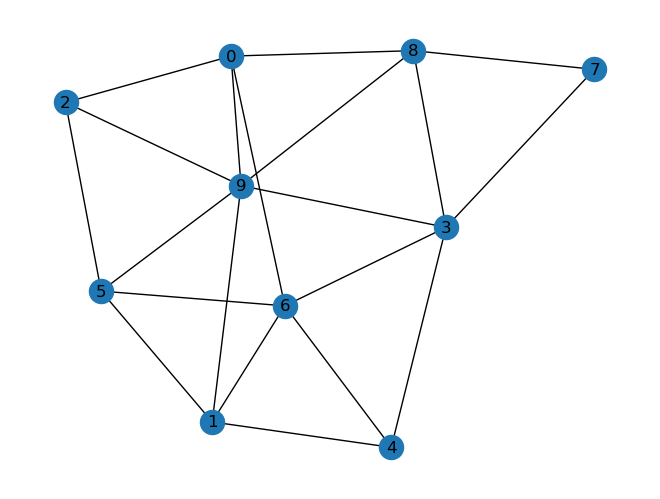

In [499]:
# g = nx.erdos_renyi_graph(10, 0.85)
nx.draw(nx.to_networkx_graph(g[0]), with_labels=True)
plt.show()

In [ ]:
nx.all_shortest_paths(G, source=0, target=1)

In [616]:
from numpy.random import choice

def clone_ind(size, population, pCl):
    idx = choice(a=size, size = int(np.ceil(pCl*size)), replace=False)
    return idx

In [106]:
nx.to_pandas_edgelist(g[0])

AttributeError: 'numpy.ndarray' object has no attribute 'edges'

In [93]:
clone_ind(300, pop, 0.2)

array([[ 18.70884148, 190.77013058,  38.72107204, ...,  83.15989904,
        148.25944698, 230.54279887],
       [306.1233886 ,  62.88785211, 103.0061957 , ...,  19.61689693,
        156.90795121,  58.65958127],
       [139.38184767, 149.67595956, 125.95519421, ...,  60.47416383,
         51.63482682, 173.36055639],
       ...,
       [227.4686476 , 185.52079432,  89.52467763, ...,  13.1235984 ,
        124.93629947, 129.51022887],
       [245.32704034,  16.91475643,  75.14821268, ...,  51.23744996,
         59.61820232,  66.28422419],
       [ 36.13963619,  51.92649775,  56.60784752, ...,  66.11945013,
        115.51201447,  37.93847363]])

In [347]:
def mutate_outga(individual, pMu=0.2):
    if random() > pMu:
        return False
    G = nx.to_networkx_graph(individual)
    edges = list(G.edges())
    n_nodes = G.number_of_nodes()
    edge = edges[choice(a=len(edges))]
    s, t = edge
    exclusion = [s, t]
    source = choice(exclusion)
    for s, t in edges:
        if s == source:
            exclusion.append(t)
        elif t == source:
            exclusion.append(s)
    
    i = choice(a=[i for i in range(n_nodes) if i not in exclusion ])
    ind = individual.copy()
    ind[s][t] = 0
    ind[t][s] = 0
    
    ind[source][i] = 1
    ind[i][source] = 1
    
    return ind


In [349]:
a = mutate_outga(g[0])

In [256]:

idx = choice(a=[i for i in range(5) if i not in [1, 2] ])
idx

3

In [350]:
g[0] == a

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True, False,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False],
       [ True,  True,  True, False,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True, False,  True,
         True]])

In [371]:
(mutate_outga(g[0])== g[0]).sum()

96

In [377]:
a = (g[0] + g[1]) / 2

In [378]:
a

array([[0. , 1. , 1. , 0.5, 0. , 0. , 0.5, 0. , 1. , 0.5],
       [1. , 0. , 1. , 1. , 0. , 0. , 0.5, 0. , 0.5, 1. ],
       [1. , 1. , 0. , 0.5, 0. , 0. , 1. , 0.5, 0. , 0. ],
       [0.5, 1. , 0.5, 0. , 1. , 1. , 0. , 0.5, 0. , 0.5],
       [0. , 0. , 0. , 1. , 0. , 0.5, 0.5, 0.5, 1. , 0.5],
       [0. , 0. , 0. , 1. , 0.5, 0. , 0.5, 0. , 0. , 0.5],
       [0.5, 0.5, 1. , 0. , 0.5, 0.5, 0. , 1. , 0.5, 0.5],
       [0. , 0. , 0.5, 0.5, 0.5, 0. , 1. , 0. , 0.5, 0.5],
       [1. , 0.5, 0. , 0. , 1. , 0. , 0.5, 0.5, 0. , 0.5],
       [0.5, 1. , 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0. ]])

In [379]:
b = np.floor(a)
b

array([[0., 1., 1., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [392]:
p = a - b
np.ceil(p).sum()

40.0

In [505]:
G = nx.to_networkx_graph(b)
edges = np.array(G.edges())
edge = edges[choice(a=len(edges), size=5,replace=False)]


In [546]:

for (i, (u,v)) in enumerate(G.edges):
    print(i ,u, v)


0 0 1
1 0 2
2 0 8
3 1 2
4 1 3
5 1 9
6 2 6
7 3 4
8 3 5
9 4 8
10 6 7


In [506]:
edge

array([[4, 8],
       [3, 4],
       [0, 8],
       [1, 2],
       [0, 2]])

In [511]:
for s, t in edge:
    print(s, t)

4 8
3 4
0 8
1 2
0 2


In [536]:

def crossover_outga(parent1, parent2, edge_size,pCr=0.8):
    if random() > pCr:
        return False
    p1, p2 = parent1.copy(), parent2.copy()
    chrom_len = len(p1)
    temp = (p1 + p2) / 2

    redundant = np.floor(temp)
    new_pair = np.ceil(temp - redundant)
    total_pair = redundant + new_pair

    redundant_sum = redundant.sum()/2
    np_sum = new_pair.sum()/2
    current_sum = redundant_sum + np_sum

    if current_sum > edge_size:
        nr_edge = int(current_sum - edge_size)
        if nr_edge == redundant_sum:
            return new_pair
        elif nr_edge < redundant_sum:
            G = nx.to_networkx_graph(redundant)
            edges = np.array(G.edges())
            print(nr_edge)
            edge = edges[choice(a=len(edges), size=nr_edge,replace=False)]
            for s, t in edge:
                redundant[s][t] = 0
                redundant[t][s] = 0
            return redundant + new_pair
        elif nr_edge > redundant_sum:
            G = nx.to_networkx_graph(total_pair)
            edges = np.array(G.edges())
            edge = edges[choice(a=len(edges), size=nr_edge,replace=False)]
            for s, t in edge:
                total_pair[s][t] = 0
                total_pair[t][s] = 0
            return total_pair


In [541]:
c = crossover_outga(g[0], g[1], 20)

In [544]:
g[1] == c

array([[ True, False, False,  True,  True,  True, False,  True,  True,
         True],
       [False,  True,  True,  True,  True, False,  True,  True,  True,
        False],
       [False,  True,  True, False,  True,  True, False,  True,  True,
         True],
       [ True,  True, False,  True, False,  True,  True,  True, False,
         True],
       [ True,  True,  True, False,  True,  True, False,  True,  True,
         True],
       [ True, False,  True,  True,  True,  True, False,  True,  True,
        False],
       [False,  True, False,  True, False, False,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False],
       [ True,  True,  True, False,  True,  True,  True,  True,  True,
        False],
       [ True, False,  True,  True,  True, False,  True, False, False,
         True]])

In [552]:
def fitness_outga(individual, flow):
    G = nx.to_networkx_graph(individual)
    min_val, max_val = np.min(flow), np.max(flow)
    scaled = (flow - min_val) / (max_val - min_val)
    for (i, (u,v)) in enumerate(G.edges):
        G[u][v]['flow'] = scaled[i]
    T = nx.average_shortest_path_length(G, weight="flow", method='dijkstra')
    return 1/T


In [ ]:
def outerga(size=10, nodes=10, edges=20, generasi=100, capacity=None, pCl=0.1, pMu=0.1, pCr=0.8):
    pop, pop_cap = generate_graph(size=size, nodes=nodes, edges=edges)

    for gen in range(generasi): 
        
        #Inner Genetic Algorithm
        def get_maxFlow(capacity):
            pop, fit = innerga(size=200, generasi=250, capacity=capacity)
            fittest = np.argmax(fit)
            flow = pop[fittest]
            return flow
        
        pop_flow = np.array([get_maxFlow(ind_cap) for ind_cap in pop_cap])
        
        fitness = np.array([fitness_outga(individual=ind, flow=ind_flow) for ind, ind_flow in zip(pop, pop_flow)])
        
        nMu = int(size * pMu)
        nCr = int(size * pCr)
        total_select = nMu + nCr
        selected = tournament_selection(size=total_select,pop=pop, fitness=fitness)

        idx = clone_ind(size=size, population=pop, pCl=pCl)
        offspring = pop[idx]
        offspring_cap = pop_cap[idx]
        
        for p1, p2 in zip(selected[:nMu:2], selected[1:nMu:2]):
            if cross := crossover_outga(parent1=p1, parent2=p2,edge_size=edges, pCr=1):
                offspring.append(cross)

        for m in list(selected[nMu:]):
            mut = mutate_outga(individual=m,pMu=1)
            offspring.append(mut)
        

    return pop, np.array([fitness_inga(capacity=capacity, flow=ind) for ind in pop])


In [609]:
pop, pop_cap = generate_graph(size=10, nodes=10, edges=20)

def get_maxFlow(capacity):
    pop, fit = innerga(size=200, generasi=250, capacity=capacity)
    fittest = np.argmax(fit)
    flow = pop[fittest]
    return flow

pop_flow = np.array([get_maxFlow(ind_cap) for ind_cap in pop_cap])

fitness = np.array([fitness_outga(individual=ind, flow=ind_flow) for ind, ind_flow in zip(pop, pop_flow)])


In [ ]:

idx = clone_ind(size=10, population=pop, pCl=0.1)
offspring = pop[idx]
offspring_cap = pop_cap[idx]


In [611]:
fitness

array([3.22126706, 6.96218282, 4.11068254, 2.29392898, 2.62799755,
       2.44289172, 3.40931268, 2.00809368, 5.88410267, 5.02315422])